# Time Series analysis of HTTP Bro Log

In [ ]:
%matplotlib notebook
import pandas as pd


## Data input

In [ ]:
http_df = pd.read_csv("resources/http.log.zip", header=None, sep="\t", 
                      names=['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'trans_depth', 'method', 'host', 'uri', 'referrer', 
                             'user_agent', 'request_body_len', 'response_body_len', 'status_code', 'status_msg', 'info_code', 'info_msg', 'filename', 'tags', 
                             'username', 'password', 'proxied', 'orig_fuids', 'orig_mime_types', 'resp_fuids', 'resp_mime_types', 'sample']) 
#resources from http://www.secrepo.com/Datasets%20Description/Network/http.html
http_df.head()

## Timestamp

In [ ]:
#clean up the timestamp column ts
from datetime import datetime
http_df['ts'] = [datetime.fromtimestamp(float(date)) for date in http_df['ts'].values]
http_df = http_df.set_index('ts')
http_df.head()
# code provided by https://github.com/sooshie/Security-Data-Analysis/blob/master/Lab_2/Lab_2-Solutions.ipynb

## Graphing time series data

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (16.0, 5.0)
df = http_df[['request_body_len','response_body_len']]
df.plot()
df.head
np.unique(df['request_body_len'])
# request_body_len means Actual uncompressed content size of the data transferred from the client
# response_body_len means Actual uncompressed content size of the data transferred from the server  
# code provided by https://github.com/sooshie/Security-Data-Analysis/blob/master/Lab_2/Lab_2-Solutions.ipynb

The figure above shows the actual umcompressed content size of data from the client and server at the end of month. You can see that blue line is very tiny which means comparing to response, it has very small amount of data size transferred.

## Resamping data

In [ ]:
%matplotlib notebook
resamp = df.resample("M", how=['mean', 'count', 'sum']) #"M" means month end frequency
resamp.plot(subplots=True)
# code provided by https://github.com/sooshie/Security-Data-Analysis/blob/master/Lab_2/Lab_2-Solutions.ipynb

The graph shows that the data that resampled by mean, number of count, total data size at the end of month

In [ ]:
resamp.plot()

Times Series Model-- ARMA(p,q)
https://en.wikipedia.org/wiki/Autoregressive–moving-average_model#ARMA_model

using ACF and PACF to determine p and q.
https://onlinecourses.science.psu.edu/stat510/node/62/

ACF and PACF
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Python code for time series
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

## Try modelling the sum of response_body_len

ARMA model is combined by two models which are Autoregressive Model(AR) and Moving Average Model(MA)
To determine the order of the model, i.e ARMA(p,q), p and q are the orders of the model, we need to plot the autocorrelation function plot(acf) to determine q, and partial autocorrelation function(pacf) plot to get p's value.

In [ ]:
%matplotlib notebook
# autocorrelation plot (acf)
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(resamp['response_body_len']['sum'])

By the acf plot, we can get q's value. Q's value depends on how many lags that are beyond the boundaries. 
According to this plot, we can get that lag 1 and maybe lag 2 are above the boundaries, so we can say that q is equal to 1 or 2. We will modelling the data for each q, and compare the Residual Mean Error Square(rmse) of each model. 

In [ ]:
# pacf partial autocorrelation func
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(resamp['response_body_len']['sum']) 

Similarly, we can use pacf to determine the p value by the same way. 

Unfortunatly, there are too many values that are larger than 1 or less than -1, i don't think it is ar model.

Therefore we could say that it is a MA model with q=1 or 2

## Fit model and predict

### Set Train and Test data

we have 37 months of data, we set first 34 months as training data, and last 3 months as test data.

In [ ]:
#train data
train = resamp['response_body_len']['sum'][0:34]
test = resamp['response_body_len']['sum'][34:37]

In [ ]:
# MA 
from statsmodels.tsa.arima_model import ARMA
# fit model q=2
model = ARMA(train, order=(0, 2))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(train),(len(resamp)-1))
print(yhat)
#Residual MSE
import math
from sklearn.metrics import mean_squared_error
rms = math.sqrt(mean_squared_error(test, yhat))
print(rms)

In [ ]:
# fit model q=1
model = ARMA(train, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(train),(len(resamp)-1))
print(yhat)
#Residual MSE
import math
from sklearn.metrics import mean_squared_error
rms = math.sqrt(mean_squared_error(test, yhat))
print(rms)

comparing two rms, we can get that if q = 1, rmse is smaller. so we choose q = 1

## MA(1)
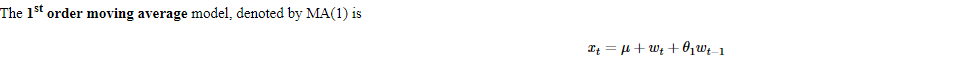
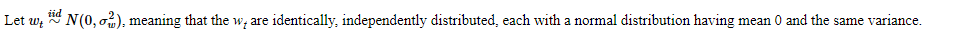
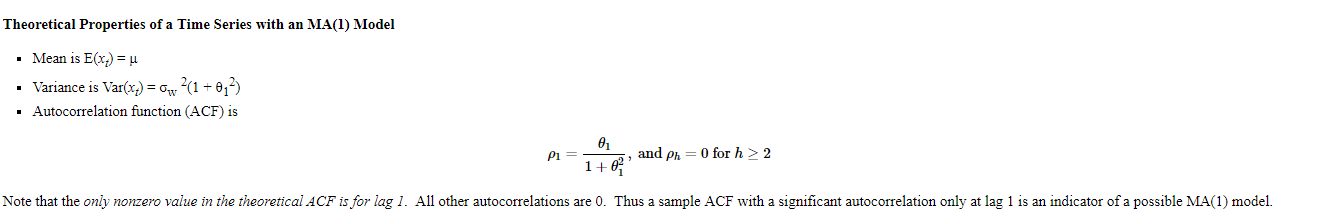